# Segmented regressions with exponential sampling and heteroscedastic noise

In [1]:
%load_ext autoreload
%autoreload 2
from pytree import *
import random
import matplotlib.pyplot as plt
import numpy

print(__version__)
print(__git_version__)

0.0.6
574b435c98866dec4200ae171284b356d12ce7e4


In [2]:
min_x = 1
max_x = 1e9
nb_breakpoints = 6
size = 1000
numpy.random.seed(27)
#breakpoints = list(sorted(numpy.exp(numpy.random.uniform(numpy.log(min_x), numpy.log(max_x), nb_breakpoints))))
breakpoints = [10**n for n in range(1, 9)]
print(f'Breakpoints: {breakpoints}')
x_list = list(sorted(numpy.exp(numpy.random.uniform(numpy.log(min_x), numpy.log(max_x), size))))
interval_idx = 0
y_list = []
tmp_break = breakpoints + [numpy.inf]
for i, x in enumerate(x_list):
    if x > tmp_break[interval_idx]:
        interval_idx += 1
    assert x <= tmp_break[interval_idx]
    slope = interval_idx
    intercept = (interval_idx+1)*10
    y_list.append(x*slope + intercept)
dataset = list(zip(x_list, y_list))

Breakpoints: [10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]


In [3]:
sigma = 0.1
noisy_dataset = [(x, y+numpy.random.normal(scale=sigma)*x) for x, y in dataset]
x = [t[0] for t in noisy_dataset] 
x = numpy.array(x)
y = [t[1] for t in noisy_dataset] 
y = numpy.array(y)

## Top-down

Here, this is the usual stuff, we add breakpoints using a tree-like approach.

/home/tom/Dropbox/Documents/Fac/phd/pytree/pytree/reg.py:520: RuntimeWarning: invalid value encountered in double_scalars
  coeff = num/denom


11
x ≤ 3.404e+04?
    └──x ≤ 2.994e+02?
    │    └──x ≤ 9.989e+00?
    │    │    └──y ~ -3.131e-02x + 1.003e+01
    │    │    └──x ≤ 9.850e+01?
    │    │         └──y ~ 9.936e-01x + 2.032e+01
    │    │         └──y ~ 2.046e+00x + 2.321e+01
    │    └──x ≤ 9.728e+03?
    │         └──x ≤ 9.936e+02?
    │         │    └──y ~ 1.947e+00x + 5.975e+01
    │         │    └──y ~ 2.989e+00x + 9.627e+01
    │         └──y ~ 3.969e+00x + 2.187e+02
    └──x ≤ 9.478e+06?
         └──x ≤ 9.923e+05?
         │    └──x ≤ 9.907e+04?
         │    │    └──y ~ 3.961e+00x + 3.191e+03
         │    │    └──y ~ 5.051e+00x + -8.645e+03
         │    └──y ~ 6.011e+00x + -1.440e+03
         └──x ≤ 9.860e+07?
              └──x ≤ 1.042e+07?
              │    └──y ~ 2.475e+01x + -1.836e+08
              │    └──y ~ 6.965e+00x + 9.377e+05
              └──y ~ 8.014e+00x + -2.188e+06
CPU times: user 16.1 s, sys: 0 ns, total: 16.1 s
Wall time: 16.1 s


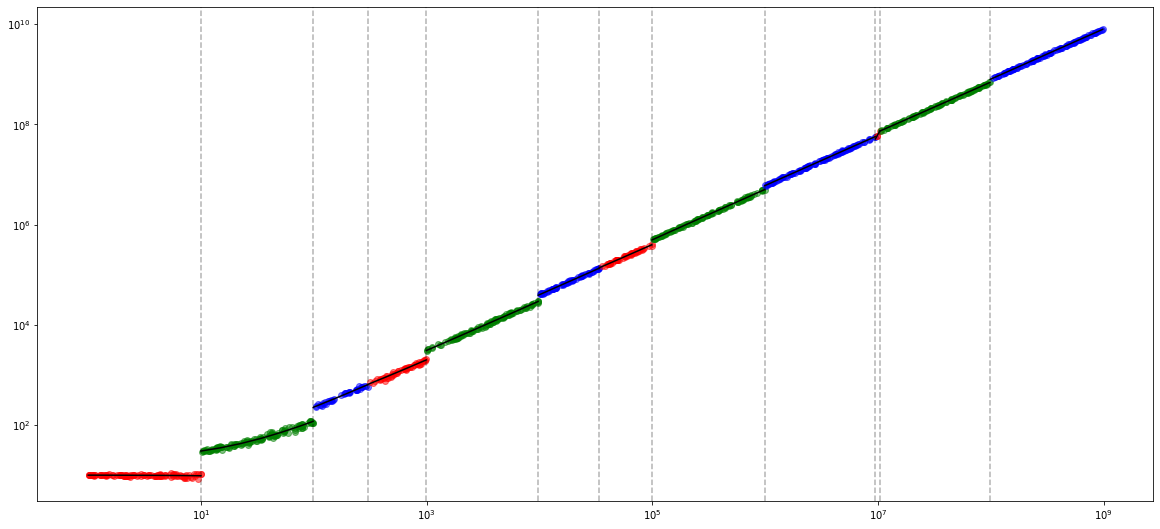

In [4]:
%%time
reg = compute_regression(x, y, mode='weighted')
print(len(reg.breakpoints))
print(reg)
reg.plot_dataset(log=True)

## Bottom-up (classical)

Here we remove breakpoints greedily, using the BIC.

In [5]:
%%time
reg.simplify()

CPU times: user 594 ms, sys: 0 ns, total: 594 ms
Wall time: 594 ms


,regression,RSS,BIC,AIC,BIClog,RSSlog,weighted_RSS,weighted_BIC,nb_breakpoints
0,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965009e+17,33236.352698,33005.688200,1.446025e+03,1.121361,8.718864,-4417.601870,11
1,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965009e+17,33208.721677,32997.688200,1.426976e+03,1.129942,8.760838,-4440.430235,10
2,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965009e+17,33181.090656,32989.688200,1.618128e+04,15.911877,84.314235,-2203.802112,9
3,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965009e+17,33153.459635,32981.688200,3.255504e+04,32.313273,300.219918,-961.468579,8
4,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965009e+17,33125.828614,32973.688200,1.646128e+05,164.398689,1618.682123,695.752728,7
5,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965009e+17,33098.197593,32965.688200,1.645877e+05,164.401183,1618.721623,668.146108,6
6,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965009e+17,33070.566582,32957.688210,inf,inf,5706.228890,1900.436737,5
7,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965011e+17,33042.936581,32949.689231,inf,inf,15566.926835,2876.395939,4
8,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965181e+17,33015.392134,32941.775805,inf,inf,33962.659675,3628.878005,3
9,"((1.0090191751595254, 10.01196389068455), (1.0...",1.966452e+17,32988.407480,32934.422172,inf,inf,34781.633270,3625.074776,2


-inf < x ≤ 9.989e+00
	y ~ -3.131e-02x + 1.003e+01
9.989e+00 < x ≤ 9.850e+01
	y ~ 9.936e-01x + 2.032e+01
9.850e+01 < x ≤ 9.936e+02
	y ~ 1.989e+00x + 3.380e+01
9.936e+02 < x ≤ 9.728e+03
	y ~ 2.989e+00x + 9.627e+01
9.728e+03 < x ≤ 3.404e+04
	y ~ 3.969e+00x + 2.187e+02
3.404e+04 < x ≤ 9.907e+04
	y ~ 3.961e+00x + 3.191e+03
9.907e+04 < x ≤ 9.923e+05
	y ~ 5.051e+00x + -8.645e+03
9.923e+05 < x ≤ 9.478e+06
	y ~ 6.011e+00x + -1.440e+03
9.478e+06 < x ≤ 1.042e+07
	y ~ 2.475e+01x + -1.836e+08
1.042e+07 < x ≤ 9.860e+07
	y ~ 6.965e+00x + 9.377e+05
9.860e+07 < x ≤ inf
	y ~ 8.014e+00x + -2.188e+06
CPU times: user 654 ms, sys: 7.96 ms, total: 662 ms
Wall time: 649 ms


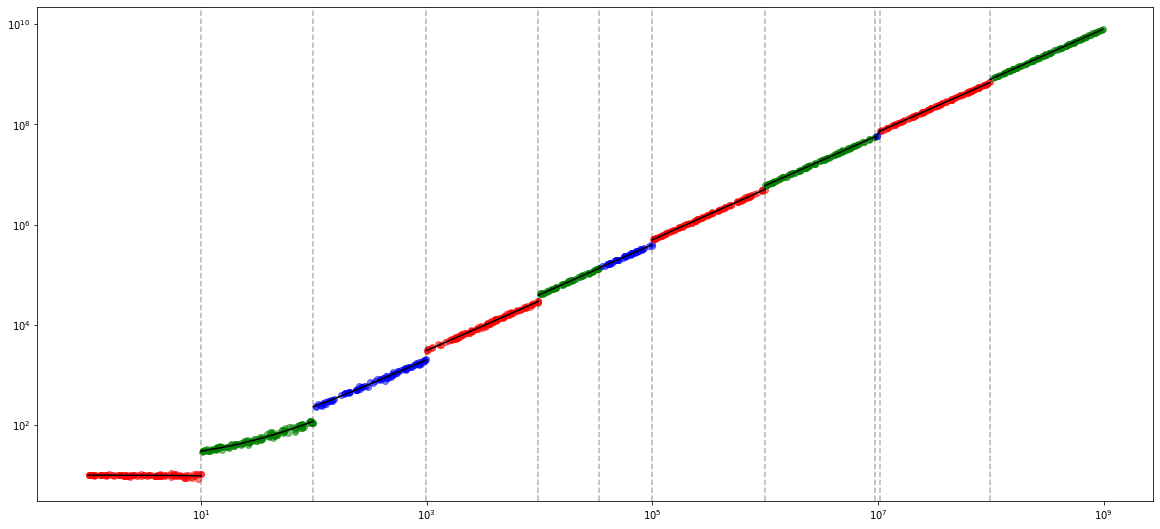

In [6]:
%%time
auto_simple = reg.auto_simplify()
print(auto_simple)
auto_simple.plot_dataset(log=True)

## Bottom-up (log)

Same algorithm as above, we remove breakpoints, but this time we changed the formula for the error.

Now, we define (with $N$ the number of points and $P$ the number of model parameters):

$$\text{RSSlog} = \sum_i \left(\log(y_i) - \log(\alpha x_i + \beta)\right)^2$$

$$\text{BIClog} = P\log(N) + N \text{RSSlog}$$

In the following simplification, we minimize this BIClog value instead of minimizing the BIC value.

In [7]:
%%time
reg.simplify(RSSlog=True)

CPU times: user 655 ms, sys: 4.07 ms, total: 659 ms
Wall time: 658 ms


,regression,RSS,BIC,AIC,BIClog,RSSlog,weighted_RSS,weighted_BIC,nb_breakpoints
0,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965009e+17,33236.352698,33005.688200,1.446025e+03,1.121361,8.718864,-4417.601870,11
1,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965009e+17,33208.721677,32997.688200,1.420887e+03,1.123854,8.758363,-4440.712790,10
2,"((1.0090191751595254, 10.01196389068455), (1.0...",1.965009e+17,33181.090656,32989.688200,1.401838e+03,1.132435,8.800337,-4463.562763,9
3,"((1.0090191751595254, 10.01196389068455), (1.0...",1.966251e+17,33154.091212,32982.319777,1.402007e+03,1.160235,9.984144,-4364.985622,8
4,"((1.0090191751595254, 10.01196389068455), (1.0...",3.261758e+17,33632.597941,33480.457527,2.359814e+03,2.145674,55.384206,-2679.320398,7
5,"((1.0090191751595254, 10.01196389068455), (1.0...",3.261830e+17,33604.988961,33472.479569,4.032052e+03,3.845542,94.779586,-2169.691834,6
6,"((1.0090191751595254, 10.01196389068455), (1.0...",3.261830e+17,33577.357944,33464.479572,1.020529e+04,10.046414,138.654670,-1816.890454,5
7,"((1.0090191751595254, 10.01196389068455), (1.0...",3.261830e+17,33549.726923,33456.479572,2.495960e+04,24.828349,214.208067,-1409.560111,4
8,"((1.0090191751595254, 10.01196389068455), (1.0...",3.261830e+17,33522.095901,33448.479572,4.133336e+04,41.229745,430.113750,-740.089242,3
9,"((1008.8580748033195, 2975.784786938555), (101...",4.300373e+17,33770.878339,33716.893031,inf,inf,34762.160884,3624.514772,2


-inf < x ≤ 9.989e+00
	y ~ -3.131e-02x + 1.003e+01
9.989e+00 < x ≤ 9.850e+01
	y ~ 9.936e-01x + 2.032e+01
9.850e+01 < x ≤ 9.936e+02
	y ~ 1.989e+00x + 3.380e+01
9.936e+02 < x ≤ 9.728e+03
	y ~ 2.989e+00x + 9.627e+01
9.728e+03 < x ≤ 9.907e+04
	y ~ 4.016e+00x + -4.516e+02
9.907e+04 < x ≤ 9.923e+05
	y ~ 5.051e+00x + -8.645e+03
9.923e+05 < x ≤ 1.042e+07
	y ~ 6.075e+00x + -1.349e+05
1.042e+07 < x ≤ 9.860e+07
	y ~ 6.965e+00x + 9.377e+05
9.860e+07 < x ≤ inf
	y ~ 8.014e+00x + -2.188e+06
CPU times: user 787 ms, sys: 0 ns, total: 787 ms
Wall time: 774 ms


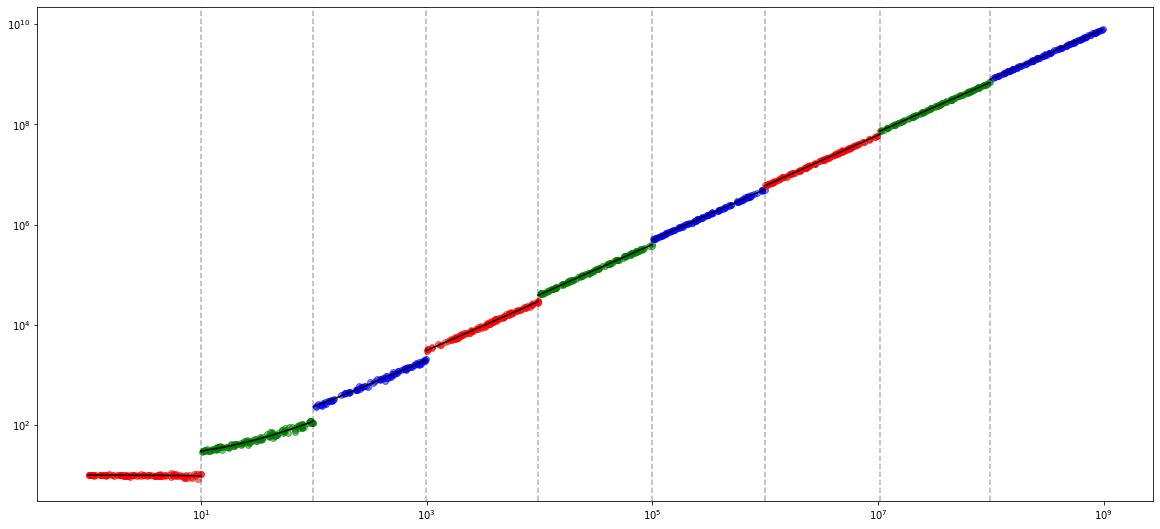

In [8]:
%%time
auto_simple = reg.auto_simplify(RSSlog=True)
print(auto_simple)
auto_simple.plot_dataset(log=True)

In [9]:
import pandas
segments = []
for i, seg in enumerate(auto_simple.segments):
    segments.append({
        'min_x': seg[0][0],
        'max_x': seg[0][1],
        'RSS': seg[1].RSS,
        'RSSlog': seg[1].compute_RSSlog(),
        'weighted_RSS': seg[1].compute_weighted_RSS(),
    })
pandas.DataFrame(segments)

,min_x,max_x,RSS,RSSlog,weighted_RSS
0,-inf,9.989428e+00,1.799220e+01,0.189045,0.976664
1,9.989428e+00,9.850368e+01,2.430442e+03,0.478724,1.296077
2,9.850368e+01,9.936408e+02,1.734526e+05,0.183642,0.802020
3,9.936408e+02,9.727959e+03,2.415735e+07,0.134220,1.224042
4,9.727959e+03,9.907217e+04,2.302752e+09,0.052323,0.835654
5,9.907217e+04,9.923422e+05,2.430035e+11,0.037036,0.934751
6,9.923422e+05,1.041554e+07,1.424005e+14,0.052825,2.087751
7,1.041554e+07,9.860397e+07,2.679203e+15,0.016589,0.810824
8,9.860397e+07,inf,1.938032e+17,0.015833,1.016361
